In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def show_data_distribution(dataset, keyname="no name", classes=classes):
    dataset_elems = len(classes)*[0]
    for image, label in dataset:
        dataset_elems[label]+=1
    plt.bar(list(classes), dataset_elems)
    plt.title(keyname)
    plt.show()

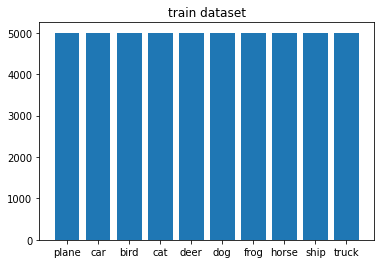

In [5]:
show_data_distribution(trainset, keyname="train dataset")

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

3. Define a Loss function and optimizer
Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [18]:
def train(trainloader, optimizer, net, criterion, epoch):
    running_loss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
    print("Finished")
    return net

In [21]:
def test(testloader, net):
    running_loss = 0.0
    net.eval()
    output_logs = []
    label_logs = []
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = labels.numpy()
        outputs = torch.argmax(net(inputs), dim=1).numpy()
        output_logs.append(outputs)
        label_logs.append(labels)
    print("Finished testing")
    return (np.concatenate(output_logs, axis=0), np.concatenate(label_logs, axis=0))

In [22]:
outputs, labels = test(testloader, net)

Finished testing


In [23]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [24]:
def get_metrics(outputs, labels):
    precision = precision_score(labels, outputs, average=None)
    max_precision = np.max(precision)
    min_precision = np.min(precision)
    mean_precision = np.mean(precision)
    
    recall = recall_score(labels, outputs, average=None)
    max_recall = np.max(recall)
    min_recall = np.min(recall)
    mean_recall = np.mean(recall)
    
    accuracy = accuracy_score(labels, outputs)
    return {
            "precision": precision,
            "recall": recall,
            "accuracy": accuracy,
            "max_precision": max_precision,
            "mean_precision": mean_precision,
            "min_precision": min_precision,
            "max_recall": max_recall,
            "mean_recall": mean_recall,
            "min_recall": min_recall
            }


In [25]:
metrics  = get_metrics(outputs, labels)
for label in metrics.keys():
    print(label, metrics[label])

precision [0.66287263 0.57589488 0.34211199 0.3982837  0.4496065  0.45522539
 0.56775362 0.58451786 0.6940649  0.63729565]
recall [0.4892 0.7626 0.5352 0.3156 0.3542 0.4504 0.6268 0.6086 0.6502 0.46  ]
accuracy 0.52528
max_precision 0.694064901793339
mean_precision 0.5367627122560691
min_precision 0.3421119918179494
max_recall 0.7626
mean_recall 0.52528
min_recall 0.3156


In [26]:
def loop(trainloader, testloader, net, optimizer, criterion, epochs=1):
    logs = []
    for i in range(epochs):
        net = train(trainloader, optimizer, net, criterion, epoch=i)
        outputs, labels = test(testloader, net)
        metrics = get_metrics(outputs, labels)
        logs.append(metrics)
    return logs

In [27]:
logs = loop(trainloader, testloader, net, optimizer, criterion, epochs=2)

[1,   200] loss: 1.340
[1,   400] loss: 1.323
[1,   600] loss: 1.330
[1,   800] loss: 1.340
[1,  1000] loss: 1.282
[1,  1200] loss: 1.325
[1,  1400] loss: 1.317
[1,  1600] loss: 1.285
[1,  1800] loss: 1.301
[1,  2000] loss: 1.292
[1,  2200] loss: 1.272
[1,  2400] loss: 1.301
[1,  2600] loss: 1.231
[1,  2800] loss: 1.284
[1,  3000] loss: 1.252
Finished
Finished testing
[2,   200] loss: 1.232
[2,   400] loss: 1.232
[2,   600] loss: 1.210
[2,   800] loss: 1.255
[2,  1000] loss: 1.206
[2,  1200] loss: 1.223
[2,  1400] loss: 1.206
[2,  1600] loss: 1.192
[2,  1800] loss: 1.237
[2,  2000] loss: 1.188
[2,  2200] loss: 1.206
[2,  2400] loss: 1.184
[2,  2600] loss: 1.192
[2,  2800] loss: 1.194
[2,  3000] loss: 1.187
Finished
Finished testing


In [28]:
import random
def long_tail(dataset, classes=10, lamda=1):
    class_indices = list(range(classes))
    random.shuffle(class_indices)
    class_probs = [lamda ** x for x in class_indices]
    select_list = []
    for i, (img, label) in enumerate(dataset):
        if np.random.binomial(1, class_probs[label]):
            select_list.append(i)
    dataset.data=dataset.data[np.array(select_list)]
    dataset.targets=list(dataset.targets[x] for x in select_list)
    return dataset

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


Files already downloaded and verified
Files already downloaded and verified


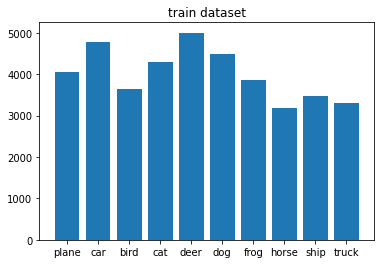

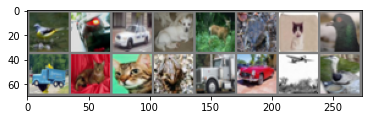

 bird   car   car   dog  deer  frog   cat  bird truck   cat   cat  frog truck   car plane  bird
length of trainset 40073
[1,   200] loss: 2.305
[1,   400] loss: 2.298
[1,   600] loss: 2.291
[1,   800] loss: 2.278
[1,  1000] loss: 2.256
[1,  1200] loss: 2.208
[1,  1400] loss: 2.155
[1,  1600] loss: 2.100
[1,  1800] loss: 2.037
[1,  2000] loss: 1.988
[1,  2200] loss: 1.919
[1,  2400] loss: 1.866
Finished
Finished testing
[2,   200] loss: 1.812
[2,   400] loss: 1.752
[2,   600] loss: 1.724
[2,   800] loss: 1.712
[2,  1000] loss: 1.641
[2,  1200] loss: 1.647
[2,  1400] loss: 1.632
[2,  1600] loss: 1.593
[2,  1800] loss: 1.585
[2,  2000] loss: 1.613
[2,  2200] loss: 1.579
[2,  2400] loss: 1.555
Finished
Finished testing
[3,   200] loss: 1.549
[3,   400] loss: 1.530
[3,   600] loss: 1.491
[3,   800] loss: 1.489
[3,  1000] loss: 1.450
[3,  1200] loss: 1.469
[3,  1400] loss: 1.462
[3,  1600] loss: 1.442
[3,  1800] loss: 1.470
[3,  2000] loss: 1.449
[3,  2200] loss: 1.417
[3,  2400] loss: 1.406

[27,   400] loss: 0.482
[27,   600] loss: 0.509
[27,   800] loss: 0.533
[27,  1000] loss: 0.548
[27,  1200] loss: 0.548
[27,  1400] loss: 0.556
[27,  1600] loss: 0.581
[27,  1800] loss: 0.609
[27,  2000] loss: 0.588
[27,  2200] loss: 0.566
[27,  2400] loss: 0.575
Finished
Finished testing
[28,   200] loss: 0.468
[28,   400] loss: 0.498
[28,   600] loss: 0.521
[28,   800] loss: 0.504
[28,  1000] loss: 0.500
[28,  1200] loss: 0.549
[28,  1400] loss: 0.535
[28,  1600] loss: 0.542
[28,  1800] loss: 0.565
[28,  2000] loss: 0.604
[28,  2200] loss: 0.567


In [ ]:
logs_by_lamda = []
for lamda in [0.95, 0.9, 0.85, 0.8, 0.75]:
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    trainset = long_tail(trainset, 10, lamda)
    show_data_distribution(trainset, keyname="train dataset")
    
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=8)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=8)

    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

    print("length of trainset", len(trainset))
    
    net = Net()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    
    logs = loop(trainloader, testloader, net, optimizer, criterion, epochs=50)
    logs_by_lamda.append({lamda: logs})